In [1]:
import os
import torch
import sys
sys.path.append("/Users/sebastian/University/Bachelor/Thesis/ba-thesis/")
from utils import load_files, get_rdms, get_rdm, get_spearmanr, inter_intra_similarity
%load_ext autoreload
%autoreload 2

In [2]:
def load_tensors(directory):
    d = {}
    for key in os.listdir(directory):
        if key.endswith(".pt"):
            filename = os.path.join(directory, key)
            tensor = torch.load(filename)
            d[key[:-3]] = tensor
    return d

In [3]:
avg = load_tensors("avg/")
clip_txt = load_tensors("sclip_txt_rdms/")
albef_txt = load_tensors("salbef_txt_rdms/")
albef_multi = load_tensors("salbef_multi_rdms/")
vilt = load_tensors("svilt_rdms/")
bert = load_tensors("sbert_txt_rdms/")
gpt = load_tensors("sgpt_rdms/")

In [4]:
avg_evc = {'EVC': avg['EVC']}
avg_rsc = {'RSC': avg['RSC']}
avg_ppa = {'PPA': avg['PPA']}
avg_opa = {'OPA': avg['OPA']}
avg_pfs = {'PFS': avg['PFS']}
avg_loc = {'LOC': avg['LOC']}

In [6]:
evc_comp = avg_evc | clip_txt | albef_txt | albef_multi | vilt | bert | gpt
rsc_comp = avg_rsc | clip_txt | albef_txt | albef_multi | vilt | bert | gpt
ppa_comp = avg_ppa | clip_txt | albef_txt | albef_multi | vilt | bert | gpt
opa_comp = avg_opa | clip_txt | albef_txt | albef_multi | vilt | bert | gpt
pfs_comp = avg_pfs | clip_txt | albef_txt | albef_multi | vilt | bert | gpt
loc_comp = avg_loc | clip_txt | albef_txt | albef_multi | vilt | bert | gpt

In [7]:
_, all_res_evc = get_spearmanr(evc_comp, 81)
_, all_res_rsc = get_spearmanr(rsc_comp, 81)
_, all_res_ppa = get_spearmanr(ppa_comp, 81)
_, all_res_opa = get_spearmanr(opa_comp, 81)
_, all_res_pfs = get_spearmanr(pfs_comp, 81)
_, all_res_loc = get_spearmanr(loc_comp, 81)

100%|███████████████████████████████████████████| 61/61 [00:02<00:00, 30.38it/s]


In [8]:
def filter_results(res, avg):
    filtered = {key: res[key] for key in list(avg.keys()) if key in res}
    return filtered

In [9]:
f_evc = filter_results(all_res_evc, avg_evc)
f_rsc = filter_results(all_res_rsc, avg_rsc)
f_ppa = filter_results(all_res_ppa, avg_ppa)
f_opa = filter_results(all_res_opa, avg_opa)
f_pfs = filter_results(all_res_pfs, avg_pfs)
f_loc = filter_results(all_res_loc, avg_loc)

In [10]:
all_filtered = {}
all_filtered['EVC'] = f_evc
all_filtered['RSC'] = f_rsc
all_filtered['PPA'] = f_ppa
all_filtered['OPA'] = f_opa
all_filtered['PFS'] = f_pfs
all_filtered['LOC'] = f_loc

In [11]:
all_filtered

{'ESC': {'EVC': {'EVC': 1.0,
   'CLIP Text Layer 9': 0.03838676578082989,
   'CLIP Text Layer 12': 0.09491690997715377,
   'CLIP Text Layer 8': 0.031245761089785423,
   'CLIP Text Layer 3': 0.08146978215720602,
   'CLIP Text Layer 7': 0.036063035479368684,
   'CLIP Text Layer 6': 0.039163646425773704,
   'CLIP Text Layer 2': 0.01799874075614462,
   'CLIP Text Layer 5': 0.024656655791975405,
   'CLIP Text Layer 1': 0.015604180148806024,
   'CLIP Text Layer 4': 0.08903405859229759,
   'CLIP Text Layer 11': 0.047011419080298836,
   'CLIP Text Layer 10': 0.03725882531876169,
   'ALBEF Text Layer 1': 0.026930148503481608,
   'ALBEF Text Layer 5': 0.07712415071364485,
   'ALBEF Text Layer 4': 0.060521450525831536,
   'ALBEF Text Layer 3': 0.027216306354469283,
   'ALBEF Text Layer 2': 0.04946603857101391,
   'ALBEF Text Layer 6': 0.07779340427872727,
   'ALBEF Multi Layer 4': 0.06674603437449875,
   'ALBEF Multi Layer 1': 0.022362388665149897,
   'ALBEF Multi Layer 5': 0.06968936032508571,
 

In [13]:
d_total = {}
for k1, v1 in all_filtered.items():
    d_inner = {}
    for k2, v2 in all_filtered[k1].items():
        d_res = {}
        d_res['Albef Text'] = []
        d_res['Albef Multi'] = []
        d_res['Gpt'] = []
        d_res['Vilt'] = []
        d_res['Clip'] = []
        d_res['Bert'] = []
        for k, v in all_filtered[k1][k2].items():
            if "VILT" in k:
                d_res['Vilt'].append((k,v))
            elif "Bert" in k:
                d_res['Bert'].append((k,v))
            elif "GPT" in k:
                d_res['Gpt'].append((k,v))
            elif "CLIP" in k:
                d_res['Clip'].append((k,v))
            elif "ALBEF Text" in k:
                d_res['Albef Text'].append((k,v))
            elif "ALBEF Multi" in k:
                d_res['Albef Multi'].append((k,v))
            else:
                continue
        d_inner[k2] = d_res
    d_total[k1] = d_inner

In [14]:
# What Im doing here is selecting for every ROI (e.g. FFA-1_lh) 
# the best layer with the highest correlation for every model
for broad_roi in d_total.keys():
    for spec_roi in d_total[broad_roi].keys():
        for model in d_total[broad_roi][spec_roi].keys():
            all_vals = d_total[broad_roi][spec_roi][model]
            tuple_with_highest_value = max(all_vals, key=lambda x: x[1])
            d_total[broad_roi][spec_roi][model] = tuple_with_highest_value

In [16]:
# Now I am combining all the best models for each ROI up to it's broader ROI level (eg FFA-1_lh -> Faces)
for broad_roi in d_total.keys():
    d_res = {}
    d_res['Albef Text'] = []
    d_res['Albef Multi'] = []
    d_res['Gpt'] = []
    d_res['Vilt'] = []
    d_res['Clip'] = []
    d_res['Bert'] = []
    for spec_roi in d_total[broad_roi].keys():
        for model in d_total[broad_roi][spec_roi].keys():
            if "Vilt" in model:
                d_res['Vilt'].append(d_total[broad_roi][spec_roi][model])
            elif "Gpt" in model:
                d_res['Gpt'].append(d_total[broad_roi][spec_roi][model])
            elif "Bert" in model:
                d_res['Bert'].append(d_total[broad_roi][spec_roi][model])
            elif "Clip" in model:
                d_res['Clip'].append(d_total[broad_roi][spec_roi][model])
            elif "Albef Text" in model:
                d_res['Albef Text'].append(d_total[broad_roi][spec_roi][model])
            elif "Albef Multi" in model:
                d_res['Albef Multi'].append(d_total[broad_roi][spec_roi][model])
    d_total[broad_roi] = d_res

In [77]:
d_total

{'ESC': {'Albef Text': [('ALBEF Text Layer 6', 0.07779340427872727)],
  'Albef Multi': [('ALBEF Multi Layer 5', 0.06968936032508571)],
  'Gpt': [('GPT Text Layer 1', 0.04137530630328651)],
  'Vilt': [('VILT Layer 2', 0.10703017123425258)],
  'Clip': [('CLIP Text Layer 12', 0.09491690997715377)],
  'Bert': [('Bert Text Layer 7', 0.057407710298538)]},
 'RSC': {'Albef Text': [('ALBEF Text Layer 3', 0.11704741563602626)],
  'Albef Multi': [('ALBEF Multi Layer 5', 0.12750902408290732)],
  'Gpt': [('GPT Text Layer 12', 0.026601473699243393)],
  'Vilt': [('VILT Layer 2', 0.12977321166840503)],
  'Clip': [('CLIP Text Layer 11', 0.14439979296429806)],
  'Bert': [('Bert Text Layer 6', 0.09495388492239105)]},
 'PPA': {'Albef Text': [('ALBEF Text Layer 3', 0.1122910168950697)],
  'Albef Multi': [('ALBEF Multi Layer 5', 0.10774053367046299)],
  'Gpt': [('GPT Text Layer 6', 0.036853637427702035)],
  'Vilt': [('VILT Layer 2', 0.1180560550965917)],
  'Clip': [('CLIP Text Layer 11', 0.14693224789006692

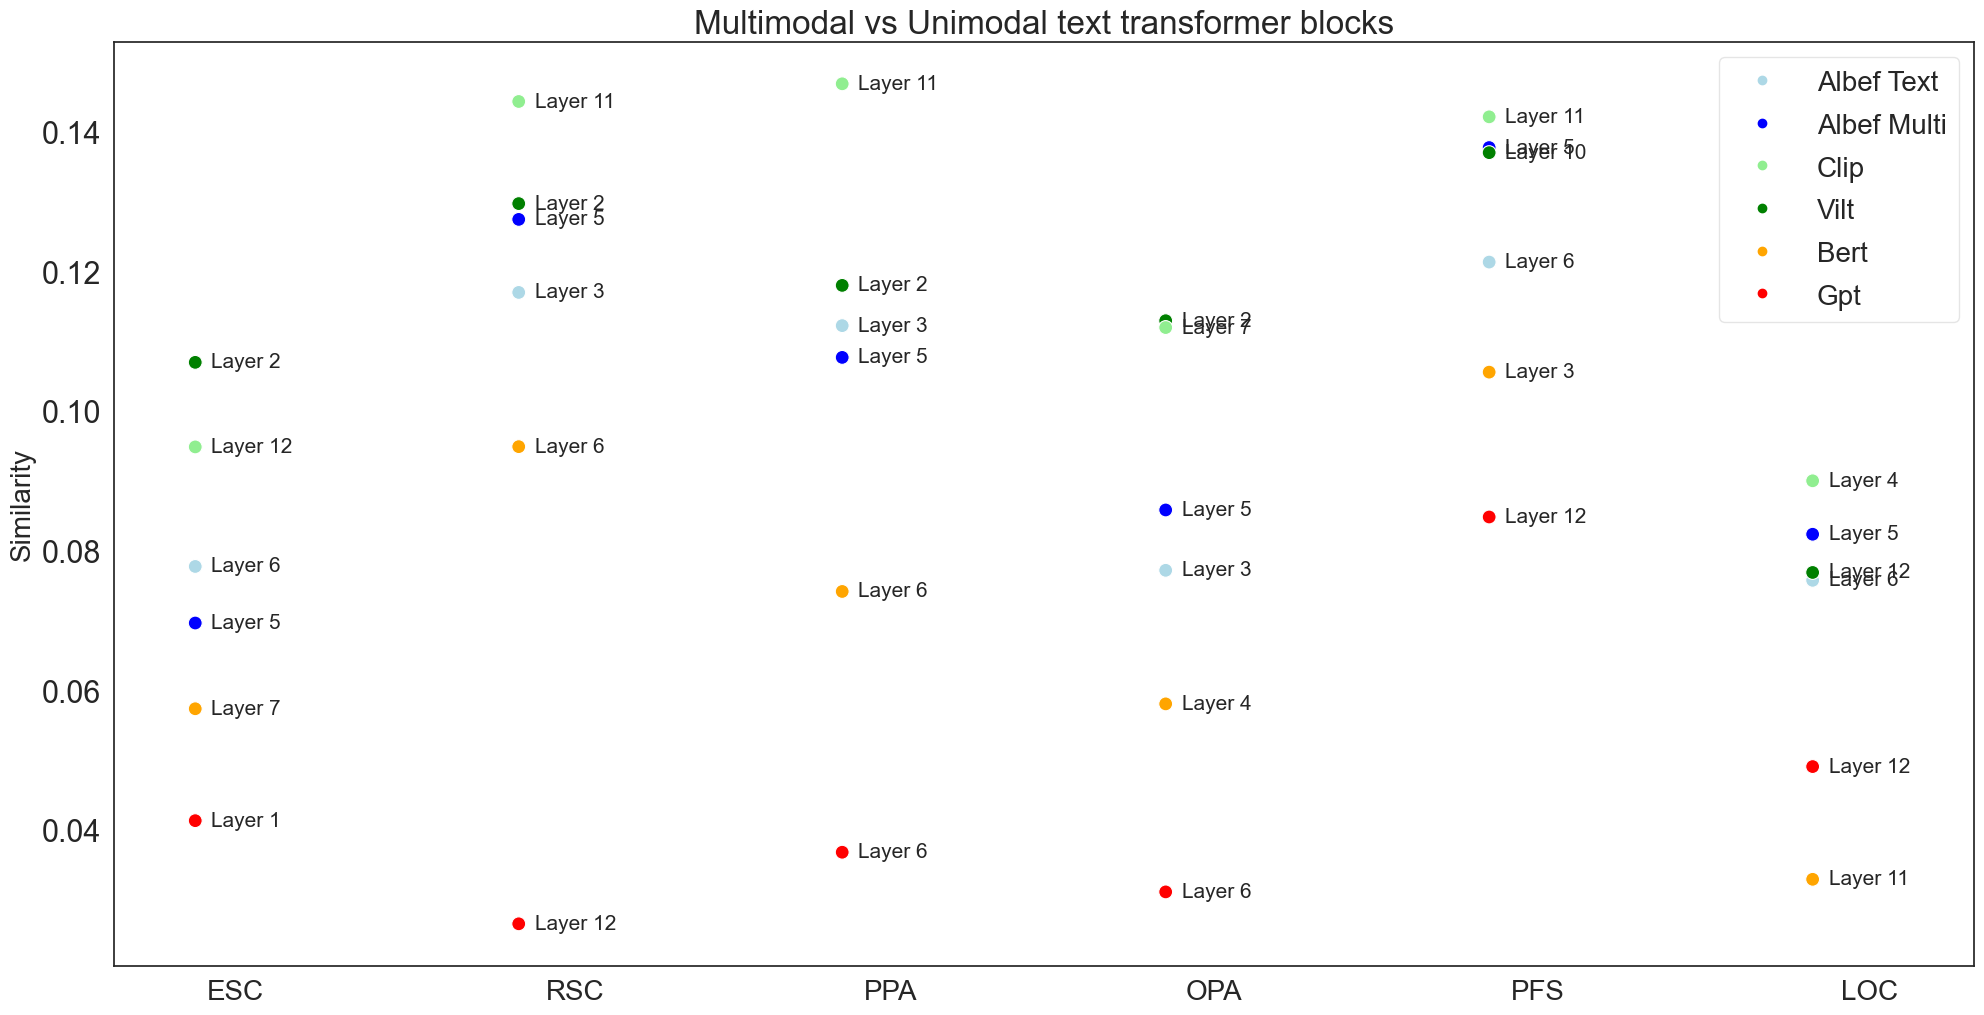

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_scatter_with_color_and_legend(data_sets):
    data_sets_names = list(data_sets.keys())
    labels = list(data_sets[data_sets_names[0]].keys())
    num_data_sets = len(data_sets)

    # Increase the figure size for larger individual scatter plots
    fig, ax = plt.subplots(figsize=(24, 12))

    # Color codes for the regions (you can change these to your desired colors)
    colors = {'Albef Text':'lightblue', 'Albef Multi': 'blue', 'Clip':'lightgreen', 
              'Vilt':'green', 'Bert': 'orange', 'Gpt': 'red'}

    # Create the scatterplot for each data set
    all_scatters = []
    i = 0
    z = 0
    for k, data_set in data_sets.items():
        l_x = []
        l_y = []
        l_label = []
        l_model = []
        df = pd.DataFrame(columns=['x', 'y', 'label', 'model_name'])
        values = [data_set[label] for label in labels]
        j = 1 + z
        for model_name in data_set.keys():
            old = data_set[model_name]
            y = [item[1] for item in old]
            x = [j for i in range(len(y))]

            #j += 1
            lab = [item[0] for item in old]
            model_n = [model_name for i in range(len(y))]
            l_x += x
            l_y += y
            l_label += lab
            l_model += model_n
        df['x'] = l_x
        df['y'] = l_y
        df['label'] = l_label
        df['model_name'] = l_model
        scatter = sns.scatterplot(x='x', y='y', data=df, hue='model_name', palette=colors, s=100, ax=ax, legend=False)
        
        for index, row in df.iterrows():
            ax.annotate(' '.join(row['label'].split(' ')[-2:]), (row['x'] + 0.2, row['y']), fontsize=15, ha='left', va='center')
        all_scatters.append(scatter)
        z += 4
        i += 1

    # Add labels to the x-axis
    ax.set_xticks([1.5, 5.7, 9.6, 13.6, 17.6, 21.7, 23])
    ax.set_xticklabels(data_sets_names + [''], fontsize=20)
    ax.set_ylabel('Similarity', fontsize=20)
    ax.set_xlabel('', fontsize=20)

    # Create a legend for the colors and data sets
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
    legend = plt.legend(markers, colors.keys(), numpoints=1)
    legend.get_frame().set_alpha(0.5)    # Set the opacity of the legend box (optional)
    for text in legend.get_texts():
        text.set_fontsize(20) 
    plt.title('Multimodal vs Unimodal text transformer blocks')
    plt.show()
    
plot_scatter_with_color_and_legend(d_total)

In [66]:
sns.set_style('white')
sns.set(font_scale=2)

In [68]:
sns.set_style('white')

In [76]:
import pickle
file_path = 'BestTextLayers.pkl'

# Save the dictionary to the file using Pickle
with open(file_path, 'wb') as file:
    pickle.dump(d_total, file)